In [1]:
import json
import numpy as np
import gurobipy
import utils
from gurobipy import Model, GRB, quicksum
import pandas as pd

In [2]:
m, data = utils.create_model('instances/toy_instance.json')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-12


In [3]:
solutions = []
m.params.outputflag = 0
m.NumScenarios = (data.Nj+1)*(data.Nm*data.Np + 1)

c1 = m.addConstr(data.f2 == 0)
c2 = m.addConstr(data.f3 == 0)

for i in range(data.Nj+1):
    for j in range(data.Nm*data.Np+1):
        m.params.ScenarioNumber = i*(data.Nm*data.Np+1) + j
        m.ScenNName = 'i = {}, j = {}'.format(i, j)
        c1.ScenNRhs = j
        c2.ScenNRhs = i

In [4]:
def tables(data: utils.ModelData):
    df_competences = pd.DataFrame(data.H)
    df_competences.rename(columns=lambda x: data.qualifications_mapping[int(x)], inplace=True)
    df_competences['membre'] = data.nom_mapping.values() 
    df_competences.set_index('membre', drop=True, inplace=True)

    df_projets = pd.DataFrame(data.Q)
    df_projets.rename(columns=lambda x: data.qualifications_mapping[int(x)], inplace=True)
    df_projets['projet'] = data.travail_mapping.values() 
    df_projets.set_index('projet', drop=True, inplace=True)

    return df_competences, df_projets

In [5]:
print("Starting optimzation...")

m.setObjective(data.f1)
m.reset()
m.optimize()

print("done.")

for s in range(m.NumScenarios):
    m.params.ScenarioNumber = s
    solutions.append([m.ScenNObjVal, data.Af.ScenNX.sum(), data.Dm.ScenNX])

m.remove(c1)
m.remove(c2)

solutions = np.array(solutions)
solutions = solutions.round().astype(int)

Starting optimzation...
done.


In [6]:
filtered_solutions = []

def dominate(s1, s2):
    temp = s1 - s2
    if max(temp) > 0 or min(temp) == 0:
        return False
    
    return True

for i in range(solutions.shape[0]):
    non_dominated = True
    for j in range(solutions.shape[0]):
        if i == j:
            continue
        if dominate(solutions[j], solutions[i]):
            non_dominated = False        
            break
    if non_dominated:
        filtered_solutions.append(solutions[i])
        
filtered_solutions = np.array(filtered_solutions)
    

In [7]:
df_solutions = pd.DataFrame(-1*filtered_solutions)

In [8]:
df_solutions

,0,1,2
0,0,0,0
1,10,-2,-1
2,20,-3,-1
3,30,-5,-1
4,37,-6,-1
5,47,-8,-1
6,49,-9,-1
7,59,-11,-1
8,10,-1,-2
9,20,-2,-2


In [ ]:
import plotly.express as px
import pandas as pd

data_plot = pd.DataFrame(filtered_solutions)
fig = px.scatter_3d(x=data_plot[0], y=data_plot[1], z=data_plot[2])
fig.show()

In [23]:
preference_list = [
    (7,   9),
    (10, 15),
    (7,  1)
]

choices = filtered_solutions[:15].copy()
nombreSolNonDominees = len(choices)

In [24]:
dim = 3
epsilon = 0
model_preorder = Model("Preorder")

Poids = {d : model_preorder.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=0.5, name = f'w{d}') for d in range(1, dim + 1)}

SommePonderee = {l+1 : quicksum([Poids[i+1]*choices[l][i] for i in range(dim)]) for l in range(nombreSolNonDominees)}

model_preorder.addConstr(quicksum(Poids.values()) == 1., name="Somme des poids = 1")
for idx, (a, b) in enumerate(preference_list):
    model_preorder.addConstr(SommePonderee[a] >= SommePonderee[b] + epsilon, name="C_"+str(idx))


model_preorder.params.outputflag = 0
model_preorder.update()

PreOrdre = {sol+1 : list() for sol in range(nombreSolNonDominees)}

for i in range(1, nombreSolNonDominees):
    for j in range(i+1, nombreSolNonDominees+1):
        obj1 = SommePonderee[i] - SommePonderee[j]
        model_preorder.setObjective(obj1, GRB.MAXIMIZE)
        model_preorder.optimize()
        if model_preorder.objVal < 0:
            PreOrdre[j].append(i)
        else:
            obj2 = - obj1
            model_preorder.setObjective(obj2, GRB.MAXIMIZE)
            model_preorder.optimize()
            if model_preorder.objVal < 0:
                PreOrdre[i].append(j)



In [17]:
import networkx as nx

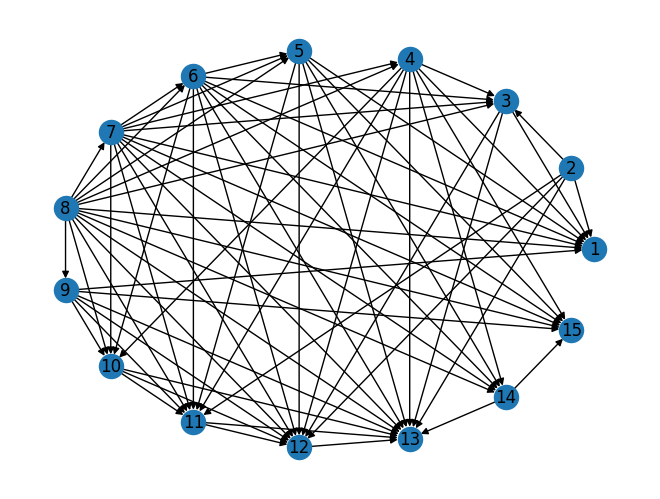

In [28]:
G = nx.DiGraph()

for node in range(nombreSolNonDominees):
    G.add_node(node+1)

for node_i in range(nombreSolNonDominees):
    for node_j in PreOrdre[node_i+1]:
        G.add_edge(node_i+1, node_j)

pos = nx.circular_layout(G)
nx.draw(G, pos,with_labels = True)